In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import copy
from numpy.linalg import svd
from numpy import linspace, meshgrid
from matplotlib.mlab import griddata


## Instructions for measuring a 3D printer bed
JWEOB 27th Feb 2016
This notebook is for investigating how level a 3D printer bed is.

1. Record a gcode file that will probe a grid of locations on your print bed. You can generate one with the script below
1. Upload the gcode file to the printer's SD card
1. SSH into the host for the printer (I use a Raspberry Pi)
2. Go to pronterface directory and run pronterface logging stdout to a file: 
`python pronterface | tee printlog.txt`
3. Connect to the printer: `connect /dev/ttyUSB0 250000`
4. Run gcode using: `sdprint file.g`
5. Exit: `exit`
6. Use filezilla to connect to pi using SFTP
7. Copy across text file, load it into the viewing script at the bottom of this notebook

## Script to generate GCODE
Take some key parameters and create a gcode file that will tell a printer to probe a grid of locations on the bed

In [24]:
probe_x_offset = 5  # i.e. probe is 5 mm to the right of the nozzle
probe_y_offset = -31 # i.e. probe is 31mm "down" from the nozzle
probe_z_offset = -22.5 # i.e. probe clicks with nozzle 22.5mm above the bed

min_y = 41
min_x = 5
max_y = 147 # Moving beyond this value after homing will crash bed
max_x = 130 # moving beyond this value will cause probe to miss bed
pre_travel_z = 27
safe_z = 32.5

x_points = 10  # Number of points in x direction
y_points = 10  # Number of points in y direction

f = open('bedread8.g', 'w')

f.write("G28\n") # Home first

x_step = (max_x - min_x) / (x_points - 1)
y_step = (max_y - min_y) / (y_points - 1)

for y_point in reversed(range(0, y_points)):
    for x_point in range(0, x_points):
        f.write('G1 X{0:.1f} Y{1:.1f} Z{2:.1f}\n'.format((x_point * x_step + min_x), (y_point * y_step + min_y), (safe_z)))
        f.write('M400\n')
        f.write('G30\n')
        f.write('M400\n')
        f.write('G1 Z{0:.1f}\n'.format(pre_travel_z))
        f.write('M400\n')
f.write('G1 Z{0:.1f}\n'.format(safe_z))
f.write('M400\n')
f.write('M402\n')
        
f.close()

## Display results
Load the file with the results and visualize them

In [25]:
f = open("bed_level_20160227_6.txt")
printlog = f.read()

In [26]:
# Extract values from logfile (only lines starting with 'Bed' are interesting)
bed_values = []
for line in iter(printlog.splitlines()):
    if line[0:3] == "Bed":
        x_start = line.index("X")
        y_start = line.index("Y")
        z_start = line.index("Z")

        bed_values.append([float(line[x_start+3:y_start]), 
                           float(line[y_start+3:z_start]), 
                           float(line[z_start+3:].rstrip(' \t\r\n\0\x00\x03'))])
        

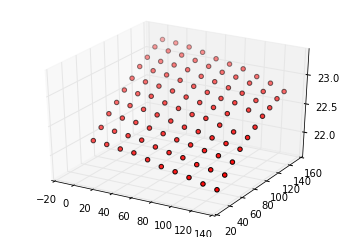

In [27]:
def plot_scatter_from_points(bed_values):
    xs = np.array([event[0] for event in bed_values])
    ys = np.array([event[1] for event in bed_values])
    zs = np.array([event[2] for event in bed_values])
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(xs, ys, zs, c='r', marker='o')
    plt.show()

plot_scatter_from_points(bed_values)

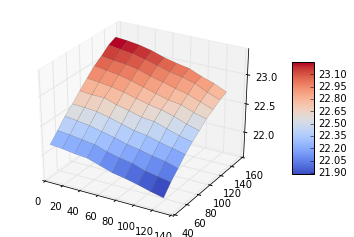

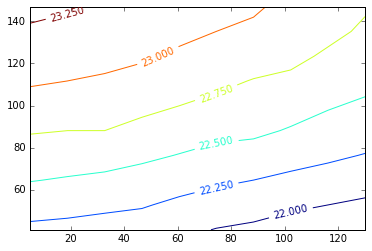

In [28]:
def plot_surface_from_points(bed_values, resX=10, resY=10):
    
    
    
    # Convert scatter plot into surface plot
    # http://stackoverflow.com/questions/18764814/make-contour-of-scatter

    x = [point[0] for point in bed_values]
    y = [point[1] for point in bed_values]
    z = [point[2] for point in bed_values]
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    
    X, Y = meshgrid(xi, yi)
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.1)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
    plt.show()
    
def plot_contour_from_points(bed_values, resX=10, resY=10):
    
    
    
    # Convert scatter plot into surface plot
    # http://stackoverflow.com/questions/18764814/make-contour-of-scatter

    x = [point[0] for point in bed_values]
    y = [point[1] for point in bed_values]
    z = [point[2] for point in bed_values]
    xi = linspace(min(x), max(x), resX)
    yi = linspace(min(y), max(y), resY)
    Z = griddata(x, y, z, xi, yi, interp='linear')
    
    X, Y = meshgrid(xi, yi)
    
    plt.figure()
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)

    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0.1)
    fig.colorbar(surf, shrink=0.5, aspect=5)
    """
    plt.show()
    
    
plot_surface_from_points(bed_values)
plot_contour_from_points(bed_values)


Need to remove the tilt from this. Get the best fit orthoganal distance regression plane using approach here: http://stackoverflow.com/questions/12299540/plane-fitting-to-4-or-more-xyz-points

In [29]:
def planeFit(points):
    """
    p, n = planeFit(points)

    Given an array, points, of shape (d,...)
    representing points in d-dimensional space,
    fit an d-dimensional plane to the points.
    Return a point, p, on the plane (the point-cloud centroid),
    and the normal, n.
    """

    points = np.reshape(points, (np.shape(points)[0], -1)) # Collapse trialing dimensions
    assert points.shape[0] <= points.shape[1], "There are only {} points in {} dimensions.".format(points.shape[1], points.shape[0])
    ctr = points.mean(axis=1)
    x = points - ctr[:,np.newaxis]
    M = np.dot(x, x.T) # Could also use np.cov(x) here.
    return ctr, svd(M)[0][:,-1]


centroid, normal = planeFit(np.transpose(np.array(bed_values)))
mag = np.sqrt(normal.dot(normal)) # Should be 1 if this is a unit vector
print(centroid, normal)

[ 67.00909091  93.94040404  22.61222222] [ 0.00364243 -0.01012004  0.99994216]


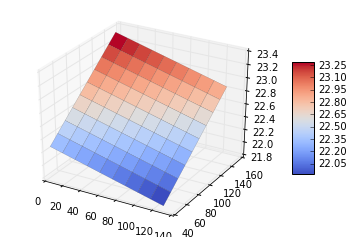

In [30]:
# Plot the plane to make sure
def get_height_on_plane(centroid, normal, x, y):
    # plane is of form ax + by +cz +d = 0
    # Normal vector of plane is [a,b,c]T, so just need to find d
    # d = -(ax0 + by0 + cz0)
    d = - np.sum((np.array(centroid) * np.array(normal)))
    [a, b, c] = normal
    z = -(a * x + b * y + d) / c
    return z

best_fit_plane = []
for point in bed_values:
    best_fit_plane.append([
            point[0],
            point[1],
            get_height_on_plane(centroid, normal, point[0], point[1])
        ]) 

plot_surface_from_points(best_fit_plane)

What is the angle between the z axis and the normal vector? Need to dot product the normal with z unit vector. http://www.intmath.com/vectors/7-vectors-in-3d-space.php

In [31]:
z_unit = np.array([0,0,1])
dot_product = normal.dot(z_unit)
tilt_angle =np.arccos(dot_product)
print("Bed is tilted by {0:.3f} degrees".format(tilt_angle))

Bed is tilted by 0.011 degrees


Now rotate the original set of points so that the best fit plane has normal equal to z axis unit vector. Use approach here: http://stackoverflow.com/questions/1023948/rotate-normal-vector-onto-axis-plane

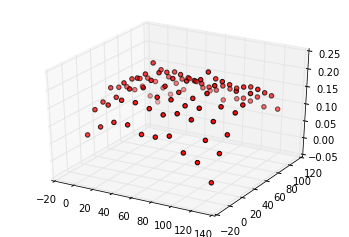

In [32]:
old_x_unit = np.array([1,0,0])
old_y_unit = np.array([0,1,0])
old_z_unit = np.array([0,0,1])

new_z_unit = np.array(normal)
new_y_unit = np.cross(old_x_unit, new_z_unit)
new_y_unit = new_y_unit / (np.dot(new_y_unit, new_y_unit))

new_x_unit = np.cross(new_z_unit, new_y_unit)
new_x_unit = new_x_unit / (np.dot(new_x_unit, new_x_unit))

# For each point, create new coords

centroid_vec = np.array(centroid)

rotated_bed_values = []

min_x = None
min_y = None
min_z = None


for point in bed_values:
    point_vec = np.array(point)
    from_centroid = point_vec - centroid_vec
    new_coords = [np.dot(from_centroid, new_x_unit),
                  np.dot(from_centroid, new_y_unit),
                  np.dot(from_centroid, new_z_unit)
    ]
    if min_z is None or np.dot(from_centroid, new_z_unit) < min_z:
        min_z = np.dot(from_centroid, new_z_unit)
    if min_y is None or np.dot(from_centroid, new_y_unit) < min_y:
        min_y = np.dot(from_centroid, new_y_unit)
    if min_x is None or np.dot(from_centroid, new_x_unit) < min_x:
        min_x = np.dot(from_centroid, new_x_unit)

    rotated_bed_values.append(new_coords)

# Make minimum point z = 0
for point in rotated_bed_values:
    point[0] -= min_x 
    point[1] -= min_y
    point[2] -= min_z

    
plot_scatter_from_points(rotated_bed_values)



/Users/jweob/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


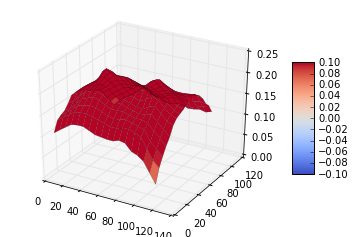

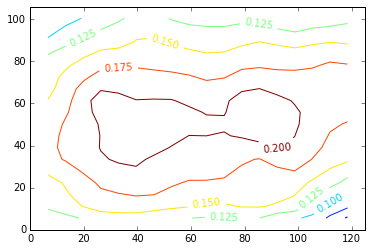

In [33]:
plot_surface_from_points(rotated_bed_values, resX=20, resY=20)
plot_contour_from_points(rotated_bed_values, resX=20, resY=20)
